In [4]:
import random
import pandas as pd
import yaml
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sim_utils.modeling import WithDropout
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

team_rb_stats = pd.read_csv("data/team_rushers.csv", index_col=0)
team_qb_stats = pd.read_csv("data/team_qb_stats.csv", index_col=0)
team_receiver_stats = pd.read_csv("data/team_receiver_stats.csv", index_col=0)
team_stats = pd.read_csv("data/agg/team_stats.csv", index_col=0).rename(
    {"recent_team": "team_name"}, axis=1
)
opp_stats = pd.read_csv("data/agg/opp_stats.csv", index_col=0).rename(
    {"opponent_team": "team_name"}, axis=1
)

In [5]:
players = pd.read_parquet("data/agg/player_weekly_agg.parquet").fillna(0)

In [6]:
players.loc[(players.player_id == "00-0036322") & (players.season == 2024)].iloc[-3]
# will ship '00-0039746'

season                                                                           2024
team_name                                                                         MIN
week                                                                             17.0
game_type                                                                         REG
depth_team                                                                        1.0
last_name                                                                   Jefferson
first_name                                                                     Justin
football_name                                                                  Justin
formation                                                                     Offense
gsis_id                                                                    00-0036322
jersey_number                                                                    18.0
position                                              

In [7]:
class masked_model(nn.Module):
    def __init__(self, n_in=11, n_out=109, n_hidden=50, dropout_prob=0.):
        super(masked_model, self).__init__()
        self.n_out=n_out
        self.main_layers = nn.Sequential(
        nn.Linear(n_in, n_hidden),nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),nn.ReLU(),
        nn.Dropout(p=dropout_prob),
        nn.Linear(n_hidden, n_hidden),nn.ReLU(),
        )
        self.add_yardline = nn.Linear(n_hidden + 1, n_out)
    def forward(self, x):
        # Extract the feature to pass to the final layer (e.g., the first feature)
        feature_to_pass = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]

        x = self.main_layers(x)
        x = torch.cat((x, feature_to_pass), dim=1) 
        x = self.add_yardline(x)



        end_zone = feature_to_pass[:,0].clone().detach().view(-1)
        accum_mask = torch.nn.functional.one_hot(end_zone.type(torch.LongTensor)+30, self.n_out)
        accum_mask =  accum_mask +  torch.sum(accum_mask, dim=1, keepdims=True) - torch.cumsum(accum_mask, dim=1)
        accum_mask = accum_mask.type(torch.bool)
        x = x.masked_fill(~accum_mask, float('-1000'))

        return x


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model_path = "models/run_yards_gained.pt"
run_yards_model = masked_model(n_in=17, n_hidden=1024, n_out=130).to(device)
run_yards_model.load_state_dict(torch.load(model_path, weights_only=True))

air_yards_path = "models/air_yards.pt"
air_yards_model = WithDropout(n_in=28, n_out=119)
air_yards_model.load_state_dict(torch.load(air_yards_path, weights_only=True))


yac_model_path = "models/yac.pt"
yac_model = WithDropout(n_in=29, n_out=125)
yac_model.load_state_dict(torch.load(yac_model_path, weights_only=True))

FileNotFoundError: [Errno 2] No such file or directory: 'models/run_yards_gained.pt'

In [157]:
stat_cols = [
    "completions",
    "attempts",
    "passing_yards",
    "passing_tds",
    "interceptions",
    "sacks",
    "sack_yards",
    "sack_fumbles",
    "sack_fumbles_lost",
    "passing_air_yards",
    "passing_yards_after_catch",
    "passing_first_downs",
    "passing_epa",
    "passing_2pt_conversions",
    "pacr",
    "dakota",
    "carries",
    "rushing_yards",
    "rushing_tds",
    "rushing_fumbles",
    "rushing_fumbles_lost",
    "rushing_first_downs",
    "rushing_epa",
    "rushing_2pt_conversions",
    "receptions",
    "targets",
    "receiving_yards",
    "receiving_tds",
    "receiving_fumbles",
    "receiving_fumbles_lost",
    "receiving_air_yards",
    "receiving_yards_after_catch",
    "receiving_first_downs",
    "receiving_epa",
    "receiving_2pt_conversions",
    "racr",
    "target_share",
    "air_yards_share",
    "wopr",
    "special_teams_tds",
    "fantasy_points",
    "fantasy_points_ppr",
]

In [158]:
class Player:
    def __init__(self, d):
        self.name = d["full_name"]
        self.id = d["gsis_id"]
        self.depth_team = int(d["dense_depth"])
        self.stats = {x: 0 for x in stat_cols}
        self.stats["air_yards"] = 0
        self.stats["yac"] = 0
        self.features = d.to_dict()

    def reset_stats(self):
        self.stats = {stat_name: 0 for stat_name in self.stats}

    def show_headshot(self):
        url = self.headshot_url
        response = requests.get(url)
        response.raise_for_status()  # Ensure the request was successful
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
        plt.axis("off")  # Turn off axis for cleaner display
        plt.show()

    def __getattr__(self, name):
        # Redirect attribute access to the stats dictionary
        if name in self.stats:
            return self.stats[name]
        elif name in self.features:
            return self.features[name]
        raise AttributeError(
            f"'{self.__class__.__name__}' object has no attribute '{name}'"
        )

    def __setattr__(self, name, value):
        if name in {
            "stats",
            "features",
            "name",
            "id",
            "depth_team",
        }:  # Handle direct attributes
            super().__setattr__(name, value)
        elif name in self.stats:  # Redirect updates to stats dictionary
            self.stats[name] = value
        elif name in self.features:  # Redirect updates to features dictionary
            self.features[name] = value
        else:
            raise AttributeError(f"Cannot set unknown attribute '{name}'")

    def stats_to_dict(self):
        out = {}
        out["name"] = self.name
        out["id"] = self.id
        out.update(self.stats)

        return out

In [159]:
def fetch_row_or_latest(df, team, season, week):
    df = df.loc[(df.team_name == team) & (df.season == season)]
    row = df.loc[(df.week == min(df.week.max(), week))].to_dict(orient="records")[0]
    return row


class QB(Player):
    def __init__(self, d):  # noqa: F811
        super().__init__(d)
        self.name = d["full_name"]
        self.features = d.to_dict()
        self.position = "QB"

    def __repr__(self):
        return f"QB:{self.name} has {self.completions} completions for {self.passing_yards} yards"


class RB(Player):
    def __init__(self, d):
        super().__init__(d)
        self.name = d["full_name"]
        self.id = d["gsis_id"]
        self.position = "RB"
        self.features = d.to_dict()

    def __repr__(self):
        return (
            f"RB:{self.name} has {self.carries} carries for {self.rushing_yards} yards"
        )


class WR(Player):
    def __init__(self, d):
        super().__init__(d)
        self.name = d["full_name"]
        self.id = d["gsis_id"]
        self.position = "WR"

    def __repr__(self):
        return f"WR:{self.name} has {self.receptions} receptions for {self.receiving_yards} yards"


class TE(Player):
    def __init__(self, d):
        super().__init__(d)
        self.name = d["full_name"]
        self.id = d["gsis_id"]
        self.position = "TE"

    def __repr__(self):
        return f"TE:{self.name} has {self.receptions} receptions for {self.receiving_yards} yards"


class K(Player):
    def __init__(self, d):
        super().__init__(d)
        self.name = d["full_name"]
        self.id = d["gsis_id"]
        self.position = "TE"

    def __repr__(self):
        return f"TE:{self.name} has {self.receptions} receptions for {self.receiving_yards} yards"


class Team:
    def __init__(self, name: str, season: int, week: int, use_current_injuries=False):
        self.name = name
        self.score = 0
        self.plays = 0
        self.features = {"last_rusher_drive": -1, "last_rusher_team": -1}
        self.team_stats = fetch_row_or_latest(team_stats, self.name, season, week)
        self.opp_stats = fetch_row_or_latest(opp_stats, self.name, season, week)
        self.roster = players.loc[
            (players.team_name == name) & (players.season == season)
        ]
        self.roster = self.roster.loc[
            (self.roster.week == min(self.roster.week.max(), week))
            & (self.roster.formation == "Offense")
            & (self.roster.position.isin(["QB", "WR", "TE", "RB", "K"]))
        ].sort_values(by="dense_depth")

        self.QBs = self.get_players_by_position("QB")
        self.RBs = self.get_players_by_position("RB")
        self.WRs = self.get_players_by_position("WR")
        self.TEs = self.get_players_by_position("TE")
        self.players = self.QBs + self.RBs + self.WRs + self.TEs
        self.rb_stats = fetch_row_or_latest(team_rb_stats, self.name, season, week)

        self.team_receiver_stats = fetch_row_or_latest(
            team_receiver_stats, self.name, season, week
        )

    def get_players_by_position(self, position: str):
        """Filter players by position and create player objects."""
        with pd.option_context("future.no_silent_downcasting", True):
            position_data = self.roster[(self.roster["position"] == position)].fillna(0)
        # Create player objects based on position
        players = []
        for _, player_data in position_data.iterrows():
            if position == "WR":
                players.append(WR(player_data))
            elif position == "RB":
                players.append(RB(player_data))
            elif position == "QB":
                players.append(QB(player_data))
            elif position == "TE":
                players.append(TE(player_data))
        return players

    def get_depth_pos(self, pos: str, depth: int):
        """input a position and team depth, to get the player
        used to go from ML output -> player object"""
        while depth >= 0:
            if pos == "WR":
                for player in self.WRs:
                    if player.depth_team == depth:
                        return player
            if pos == "RB":
                for player in self.RBs:
                    if player.depth_team == depth:
                        return player
            if pos == "TE":
                for player in self.TEs:
                    if player.depth_team == depth:
                        return player
            if pos == "QB":
                for player in self.QBs:
                    if player.depth_team == depth:
                        return player
            depth -= 1
        print(pos, depth, self.name)
        raise ValueError("You want a player that does not exist")

    def game_results(self, df=False):
        r = [
            {"team_name": self.name, "position": x.position, "id": x.id}
            | x.stats_to_dict()
            for x in self.players
        ]
        if df:
            return pd.json_normalize(r)
        return r

    def reset_stats(self):
        [x.reset_stats() for x in self.players]
        self.score = 0
        self.plays = 0

    def __repr__(self):
        return f"{self.name} has {self.score} points"

In [160]:
vik = Team("MIN", 2024, 13)
det = Team("DET", 2024, 13)

In [161]:
from abc import ABC, abstractmethod


class Play(ABC):
    def __init__(self, game):
        self.game = game
        self.clock_cols = game.config["clock_cols"]
        self.clock_model = joblib.load("models/clock_model.joblib")
        self.play_context = {}
        self.play_data = {'incomplete_pass':0,
                          'out_of_bounds':0,
                      'player':None,
                      'timeout': 0,
                      'sp': 0}

    @abstractmethod
    def execute_play(self, team):
        return
    
    def log_play(self, play_type, yds, verbose=False):
        """Logs the context of the game state at each play."""
        play_data = {
            "play_type": play_type,
            "yards_gained": yds,
            "player": self.play_data['player'],
        }
        play_data.update(self.game.game_context)
        if verbose:
            print(
                f'{self.game.possession.name} {play_type} for {yds} yards, {self.game.pbp[-1]['yardline_100']} yd line,'
                + f' {self.game.pbp[-1]['ydstogo']} yds to go on {self.game.pbp[-1]['down']} down.'
                + f' {self.game.pbp[-1]['quarter_seconds_remaining'] // 60}:{self.game.pbp[-1]['quarter_seconds_remaining']  % 60} left'
            )
        self.game.pbp.append(play_data)
        return play_data
    
    def sample_clock(self, play_type):
        #this is the time from the previous play, until the next play starts.
        raw_features = self.collect_features(
            {"next_play": self.game.int_from_play[play_type]},
             self.game.pbp[-1],
            self.play_data
        )
        raw_features['play_type_enc'] = self.game.int_from_play[self.game.pbp[-1]['play_type']]
        # print(self.pbp[-1])
        features = np.array([[raw_features[key] for key in self.clock_cols]])
        t = self.clock_model.predict(features).item()
        #print(t, play_type)
        return t
        #return random.randint(15, 40)

    def update_game_state(self, team, yards):
        if self.play_type not in ["field_goal", "punt", "pos_timeout", "def_timeout"]:
            self.game.ydstogo -= yards
            self.game.ball_position -= yards
            self.game.td_check(team)
            self.game.check_downs(team)
    
    def orchestrate(self, team):
        yards = self.execute_play(team)
        self.update_game_state(team, yards)

    def collect_features(self, *argv):
        features = {}
        features.update(self.game.game_context)
        for arg in argv:
            features.update(arg)
        return features


class RunPlay(Play):
    def __init__(self, game):
        super().__init__(game)
        self.play_type='run'
        self.choose_rusher_model = joblib.load("models/choose_rusher.joblib")
        self.choose_rusher_cols = game.config["choose_rusher_cols"]
        self.rusher_idx_to_pos = game.config["rusher_idx_to_pos"]
        self.rush_yard_cols = game.config["rush_yard_cols"]

    def choose_rusher(self, team):
        raw_features = self.collect_features(
            team.rb_stats,
            team.features,
            self.game.defending.opp_stats,
        )
        features = [raw_features[key] for key in self.choose_rusher_cols]
        preds = self.choose_rusher_model.predict_proba([features])
        rusher_idx = np.random.choice(len(preds[0]), p=preds[0])
        pos, depth = self.rusher_idx_to_pos[rusher_idx].split("_")
        player = team.get_depth_pos(pos, int(depth))
        team.features["last_rusher_team"] = rusher_idx
        team.features["last_rusher_drive"] = rusher_idx
        return player

    def sample_run_yards(self, model, team, player):
        raw_features = self.collect_features(
            player.features,
            team.team_stats,
            team.opponent.opp_stats,
        )
        x = [raw_features[key] for key in self.rush_yard_cols]
        x = torch.tensor(x).to(device)
        with torch.no_grad():
            preds = model(x.reshape(1, -1))[0]
            preds = torch.softmax(preds, 0)
        sample = (torch.multinomial(preds, 1)).item() - 30
        return min((sample, raw_features["yardline_100"]))

    def execute_play(self, team):
        player = self.choose_rusher(team)
        yds = self.sample_run_yards(run_yards_model, team, player)
        self.player = player
        return yds

    def update_game_state(self, team, yds):
            self.player.carries += 1
            self.player.rushing_yards += yds
            self.game.player = self.player.name
            return

    def sample_run_yards_quant(self, model, team, player):
        raw_features = self.collect_features(
            player.features,
            team.team_stats,
            team.opponent.opp_stats,
        )
        x = [raw_features[key] for key in self.rush_yard_cols]
        x = np.array([x])
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            quantile = np.random.randint(0,100)/100
            sample = model.predict(x, quantiles=quantile)
        return round(sample[0])
    

class PassPlay(Play):
    def __init__(self, game):
        super().__init__(game)
        self.play_type='pass'
        self.choose_receiver = joblib.load("models/choose_receiver.joblib")
        self.choose_receiver_cols = game.config["choose_receiver_cols"]
        self.air_yards_cols = game.config["air_yards_cols"]
        self.receiver_idx_to_pos = game.config["receiver_idx_to_pos"]
        self.complete_pass_cols = game.config["complete_pass_cols"]
        self.complete_pass_model = joblib.load("models/complete_pass.joblib")

    def sample_air_and_yac(self, air_model, yac_model, team, player):
        raw_features = self.collect_features(
            player.features,
            team.team_stats,
            team.opponent.opp_stats,
        )
        x = [raw_features[key] for key in self.air_yards_cols]
        x = torch.tensor(x)
        with torch.no_grad():
            preds = air_model(x.reshape(1, -1))[0]
            preds = torch.softmax(preds, 0)
        air_yards = (torch.multinomial(preds, 1)).item() - 20
        if air_yards >= self.game.ball_position:  # touchdown at catch
            return self.game.ball_position, 0

        x = torch.cat((x, torch.tensor([air_yards])))
        with torch.no_grad():
            preds = yac_model(x.reshape(1, -1))[0]
            preds = torch.softmax(preds, 0)
        yac = (torch.multinomial(preds, 1)).item() - 25
        yac = min(yac, (self.game.ball_position - air_yards))
        self.play_context.update({'air_yards':air_yards,
                          'yac': yac})
        return air_yards, yac

    def sample_completion(self, qb, receiver, team, air_yards):
        raw_features = self.collect_features(
            receiver.features,
            team.team_stats,
            team.opponent.opp_stats,
        )
        raw_features["air_yards"] = air_yards
        qb_features = {(key + "_qb"): value for key, value in qb.features.items()}
        raw_features.update(qb_features)
        features = [raw_features[key] for key in self.complete_pass_cols]
        preds = self.complete_pass_model.predict_proba([features])
        receiver = np.random.choice(len(preds[0]), p=preds[0])
        return np.random.choice(len(preds[0]), p=preds[0])
    
    def get_receiver(self, team):
        raw_features = self.collect_features(
            team.team_receiver_stats,
            team.features,
        )
        features = [raw_features[key] for key in self.choose_receiver_cols]
        preds = self.choose_receiver.predict_proba([features])
        receiver = np.random.choice(len(preds[0]), p=preds[0])
        pos, depth = self.receiver_idx_to_pos[receiver].split("_")
        receiver = team.get_depth_pos(pos, int(depth))
        return receiver

    def execute_play(self, team):
        passer = team.QBs[0]
        receiver = self.get_receiver(team)
        passer.attempts += 1
        receiver.targets += 1
        air_yards, yac = self.sample_air_and_yac(
            air_yards_model, yac_model, team, receiver
        )

        if self.sample_completion(passer, receiver, team, air_yards):
            passer.completions += 1
            receiver.receptions += 1
            yds = air_yards + yac
            receiver.air_yards += air_yards
            receiver.yac += yac
            receiver.receiving_yards += yds
            passer.passing_yards += yds
        else:
            yds = 0
        self.play_data['player'] = receiver.name
        return yds


class FieldGoal(Play):
    def __init__(self, game):
        super().__init__(game)
        self.play_type='field_goal'

    def execute_play(self, team):
        result = random.randint(0, 100)
        if result > (10 + (1.7 * self.game.ball_position)):
            team.score += 3
            self.game.switch_poss()
            self.game.ball_position = 65
            # print(f'{team.name} scored a FG')
        else:
            # print(f'{team.name} missed FG')
            self.game.switch_poss()
        self.game.player = None
        return 0


class Punt(Play):
    def __init__(self, game):
        super().__init__(game)
        self.play_type='punt'

    def execute_play(self, team):
        return 0
    
    def update_game_state(self, team, yards):
        self.game.switch_poss()
        self.game.ball_position += random.randint(45, 60)
        if self.game.ball_position >= 100:
            self.game.ball_position = 20
        self.game.player = None
        return 0

class Kneel(Play):
    def __init__(self, game):
        super().__init__(game)
        self.play_type='qb_kneel'
    def execute_play(self, team):
        # Implementation of qb kneel play
        # print("QB kneel executed.")
        return -1


class Spike(Play):
    def __init__(self, game):
        super().__init__(game)
        self.play_type='qb_spike'

    def execute_play(self, team):
        # Implementation of qb spike play
        # print("QB spike executed.")
        return -1


class PosTimeout(Play):
    def __init__(self, game):
        super().__init__(game)
        self.play_type='pos_timeout'
    def execute_play(self, team):
        self.game.possession.timeouts -= 1
        #print(f"TIMEOUT! {self.game.possession.timeouts} remaining")
        return 0


class DefTimeout(Play):
    def __init__(self, game):
        super().__init__(game)
        self.play_type='def_timeout'
    def execute_play(self, team):
        self.game.defending.timeouts -= 1
        #print(f"def TIMEOUT!, {self.game.defending.timeouts} remaining")
        return 0



In [162]:
qrf_run_yards = joblib.load("models/rush_yards_qrf.joblib")

In [163]:
import warnings

In [164]:
r = RunPlay(game)
val = r.sample_run_yards(qrf_run_yards, vik, vik.RBs[0])
val

AttributeError: 'Team' object has no attribute 'opponent'

In [165]:
class GameState:
    def __init__(self, away, home, config, **kwargs):
        self.config = config
        self.home = home
        self.away = away
        home.opponent = self.away
        away.opponent = self.home
        home.spread_line = kwargs.get("spread_line", -3)
        away.spread_line = -1 * self.home.spread_line
        self.total_line = kwargs.get("total_line", 42)
        self.run_or_pass = joblib.load("models/run_or_pass.joblib")
        self.run_or_pass_cols = config["run_or_pass_cols"]
        self.play_encoding = config["play_encoding"]
        self.int_from_play = {v:k for k,v in self.play_encoding.items()}
        self.wind = kwargs.get("wind", random.randint(0, 10))
        self.temp = kwargs.get("temp", random.randint(40, 90))
        self.play_functions = {
            "field_goal": FieldGoal(self),
            "no_play": RunPlay(self),
            "pass": PassPlay(self),
            "punt": Punt(self),
            "qb_kneel": Kneel(self),
            "qb_spike": Spike(self),
            "run": RunPlay(self),
            "pos_timeout": PosTimeout(self),
            "def_timeout": DefTimeout(self),
        }
        self.reset_game()
        self.game_context = self.get_game_state()   

    def reset_game(self):
        self.quarter = 1
        self.possession = self.home
        self.defending = self.away
        self.down = 1
        self.ydstogo = 10
        self.ball_position = 65  # Yardline (0-100), 0 is score, 100 is safety
        self.clock = 900  # Seconds in the current quarter (15 mins = 900 seconds)
        self.drive = 0
        self.pbp = []
        self.player = None
        self.home.timeouts = 3
        self.away.timeouts = 3
        self.home.reset_stats()
        self.away.reset_stats()

    def switch_poss(self):
        self.possession.features["last_rusher_drive"] = -1
        self.possession = self.away if self.possession == self.home else self.home
        self.defending = self.possession.opponent
        self.ball_position = 100 - min(self.ball_position, 99)
        self.down = 1
        self.ydstogo = min(10, self.ball_position)
        self.drive += 1
        return

    def kickoff(self):
        self.switch_poss()
        self.ball_position = 65
        self.log_play('kickoff',0)
        pass

    def start_game(self):
        self.lost_kickoff = random.choice((self.home, self.away))
        self.possession = self.lost_kickoff
        self.kickoff()
        self.game_context = self.get_game_state()
        # print(f"{self.possession.name} has won the kickoff")
        self.log_play("kickoff", 0)

    def collect_features(self, *argv):
        features = {}
        features.update(self.game_context)
        for arg in argv:
            features.update(arg)
        return features

    def get_game_state(self):
        """Logs the context of the game state at each play."""
        play_data = {
            "possession": self.possession.name,
            "quarter": self.quarter,
            "down": self.down,
            "ydstogo": self.ydstogo,
            "goal_to_go": int(self.ball_position < 10),
            "yardline_100": self.ball_position,
            "total_home_score": self.home.score,
            "total_away_score": self.away.score,
            "posteam_score": self.possession.score,
            "defteam_score": self.defending.score,
            "score_differential": (self.possession.score - self.defending.score),
            "wind": self.wind,
            "temp": self.temp,
            "quarter_seconds_remaining": self.clock,
            "half_seconds_remaining": self.clock + (900 * (self.quarter % 2)),
            "game_seconds_remaining": self.clock + (900 * (4 - self.quarter)),
            "drive": self.drive,
            "spread_line": self.possession.spread_line,
            "total_line": self.total_line,
            "posteam_timeouts_remaining": self.possession.timeouts,
            "defteam_timeouts_remaining": self.defending.timeouts,
        }
        return play_data

    def play(self, team):
        self.game_context = self.get_game_state()
        team.plays += 1
        raw_features = self.collect_features(
            team.team_stats,
            self.defending.opp_stats,
        )
        features = [raw_features[key] for key in self.run_or_pass_cols]
        preds = self.run_or_pass.predict_proba([features])
        if self.possession.timeouts == 0:
            preds[:, 7] = 0
            preds /= preds.sum()
        if self.defending.timeouts == 0:
            preds[:, 8] = 0
            preds /= preds.sum()
        play_type_int = np.random.choice(len(preds[0]), p=preds[0])
        play_type = self.play_encoding.get(play_type_int, 1)
        self.clock -= self.play_functions[play_type].sample_clock(play_type)
        yds = self.play_functions[play_type].orchestrate(team)
        self.log_play(play_type, yds)



    def log_play(self, play_type, yds, verbose=False):
        """Logs the context of the game state at each play."""
        play_data = {
            "play_type": play_type,
            "yards_gained": yds,
            "player": self.player,
        }
        play_data.update(self.game_context)
        if verbose:
            print(
                f'{self.possession.name} {play_type} for {yds} yards, {self.pbp[-1]['yardline_100']} yd line,'
                + f' {self.pbp[-1]['ydstogo']} yds to go on {self.pbp[-1]['down']} down.'
                + f' {self.pbp[-1]['quarter_seconds_remaining'] // 60}:{self.pbp[-1]['quarter_seconds_remaining']  % 60} left'
            )
        self.pbp.append(play_data)
        return play_data

    def td_check(self, team):
        if self.ball_position <= 0:
            team.score += 7
            self.pbp[-1]
            self.kickoff()
            # print(f'{team.name} scored a TD')
        return

    def check_downs(self, team):
        if self.ydstogo <= 0:
            self.ydstogo = 10
            self.down = 1
        elif self.down == 4:
            self.switch_poss()
        else:
            self.down += 1

    def play_quarter(self):
        self.clock = 900
        if self.quarter == 3:
            self.kickoff()
            self.possession = self.lost_kickoff
        if self.quarter == 3:
            self.home.timeouts = 3
            self.away.timeouts = 3
        while self.clock > 0:
            self.play(self.possession)
        self.quarter += 1
        # print(f"{self.home.name}:{self.home.score}")
        # print(f"{self.away.name}:{self.away.score}")

    def play_game(self):
        self.reset_game()
        self.start_game()
        while self.quarter <= 4:
            self.play_quarter()
            # print(self.quarter)
        if self.home.score > self.away.score:
            print(f"{self.home.name} has won {self.home.score} - {self.away.score}")
        else:
            print(f"{self.away.name} has won {self.away.score} - {self.home.score}")

    def game_results(self, df=False):
        res1 = self.home.game_results(df=False)
        res2 = self.away.game_results(df=False)
        res = res1 + res2
        if df:
            return pd.DataFrame(res)
        return res

In [166]:
qrf_run_yards = joblib.load("models/rush_yards_qrf.joblib")
qrf_run_yards

RandomForestQuantileRegressor(max_depth=8, max_samples=0.25,
                              min_samples_leaf=32,
                              monotonic_cst=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1,
                                             0, 0, 0, 1, 1, 1],
                              n_jobs=16)

In [167]:
def test():
    a = []

    p = RunPlay(game)
    for i in range(100):
        _ = p.choose_rusher(vik)
        a.append(_)
    return a

import cProfile
cProfile.run('test()')

         20768 function calls in 0.097 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.095    0.095 1694628362.py:1(test)
      100    0.000    0.000    0.000    0.000 4142839037.py:110(get_depth_pos)
        1    0.000    0.000    0.005    0.005 656567253.py:5(__init__)
      100    0.000    0.000    0.001    0.000 656567253.py:63(collect_features)
        1    0.000    0.000    0.033    0.033 656567253.py:72(__init__)
      100    0.002    0.000    0.062    0.001 656567253.py:80(choose_rusher)
      200    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:645(parent)
        2    0.000    0.000    0.000    0.000 <frozen ntpath>:179(splitroot)
        2    0.000    0.000    0.000    0.000 <frozen ntpath>:236(split)
        2    0.000    0.000    0.000    0.000 <frozen ntpath>:275(dirname)
        2    0.000    0.000    0.000    0.000 <frozen ntpath>:35(_get_bothseps)
        1 

In [177]:
with open("models/feature_config.yaml", "r") as file:
    config = yaml.safe_load(file)

vik = Team("LV", 2024, 13)
det = Team("PHI", 2024, 13)
game = GameState(vik, det, config, **{"wind": 5, "temp": 90, "spread_line": -12.5})
game.play_game()
game.game_results(df=True).groupby(["team_name"]).sum()[
    ["receiving_yards", "rushing_yards"]
]


PHI has won 21 - 14


,receiving_yards,rushing_yards
team_name,,
LV,247,112
PHI,215,219


In [ ]:
vik.players

[QB:Gardner Minshew has 15 completions for 266 yards,
 QB:Desmond Ridder has 0 completions for 0 yards,
 RB:Zamir White has 5 carries for 38 yards,
 RB:Alexander Mattison has 6 carries for 31 yards,
 RB:Dylan Laube has 2 carries for 8 yards,
 RB:Ameer Abdullah has 0 carries for 0 yards,
 WR:Jakobi Meyers has 3 receptions for 32 yards,
 WR:Tre Tucker has 2 receptions for 49 yards,
 WR:D.J. Turner has 2 receptions for 67 yards,
 WR:Ramel Keyton has 0 receptions for 0 yards,
 TE:Harrison Bryant has 0 receptions for 0 yards,
 TE:Brock Bowers has 7 receptions for 73 yards,
 TE:Justin Shorter has 0 receptions for 0 yards]

In [ ]:
for i in range(1000000):
    n = np.random.randint(0,100)
    x  = dist[0][n]

In [ ]:
df = game.game_results(df=True).groupby(["team_name"]).sum()[
    ["receiving_yards", "rushing_yards", "carries"]
]
df['ypc'] = df['rushing_yards'] / df['carries'] 
df

,receiving_yards,rushing_yards,carries,ypc
team_name,,,,
DET,271,228,56,4.071429
PHI,119,224,33,6.787879


In [ ]:
a = []
p = PassPlay(game)
for i in range(3000):  # 2.2 with gpu
    a.append(p.sample_air_and_yac(air_yards_model, yac_model, det, det.WRs[0]))

(array([  2.,   3.,   0.,   1.,   1.,   1.,   2.,   0.,   2.,   2.,   5.,
         20.,  19.,  40.,  59.,  83.,  91., 110., 113., 173., 114., 150.,
        137., 173., 171., 117., 103.,  74.,  88.,  84.,  63.,  70.,  69.,
         55.,  61.,  61.,  49.,  39.,  35.,  39.,  29.,  38.,  31.,  28.,
         19.,  18.,  15.,  16.,  22.,  10.,  15.,  13.,  14.,  14.,  11.,
          8.,  10.,  20.,  21.,  10.,  11.,  12.,   5., 131.]),
 array([-19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,
         -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,
          3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
         14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
         25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.]),
 <BarContainer object of 64 artists>)

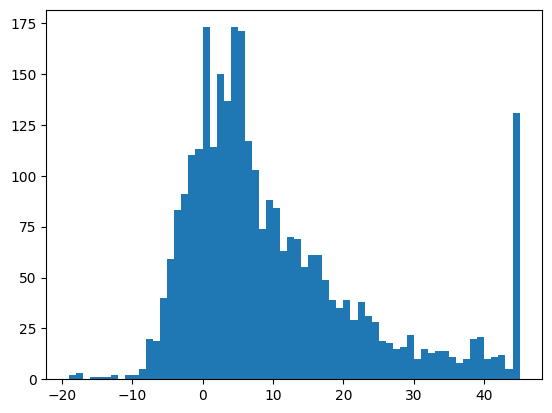

In [ ]:
air = [x[0] for x in a]
plt.hist(air, bins=max(air) - min(air))

In [ ]:
pd.DataFrame(air).value_counts()

0  
 4     173
 0     173
 5     171
 2     150
 3     137
      ... 
-11      2
-13      2
-15      1
-14      1
-16      1
Name: count, Length: 63, dtype: int64

In [ ]:
def run_sim(team1, team2, num_sims, config=config):
    results = []
    scores = []
    vik = Team(team1, 2024, 13)
    det = Team(team2, 2024, 13)
    game = GameState(vik, det, config, **{"wind": 5, "temp": 60, "spread_line": 6.5})
    for i in range(num_sims):
        game.start_game()
        game.play_game()
        scores.append((game.home.score, game.away.score))
        res = vik.game_results() + det.game_results()
        for result in res:
            result["game_number"] = i
        results += res
    return results, scores


results, scores = run_sim(
    "CAR", "PHI", 100
)  # 28.8 -> 22.8 by pulling game initialization out of loop

CAR has won 38 - 28
PHI has won 35 - 28
PHI has won 24 - 14
CAR has won 35 - 34
CAR has won 42 - 28
CAR has won 34 - 24
CAR has won 42 - 28
CAR has won 21 - 21


KeyboardInterrupt: 

In [ ]:
sum([x[0] / 50 for x in scores])

20.240000000000002

In [ ]:
sum([x[0] > x[1] for x in scores])

43

In [ ]:
(1909 + 2191)

4100

In [ ]:
df = pd.json_normalize(results)
df.groupby(["name", "id"])[
    [
        "receiving_yards",
        "targets",
        "receptions",
        "air_yards",
        "completions",
        "attempts",
        "rushing_yards",
        "carries",
    ]
].agg(["median", "mean"]).sort_values(by=[("receiving_yards", "mean")], ascending=False)

receiving_yards        targets       receptions  \
                                      median   mean  median  mean     median   
name              id                                                           
A.J. Brown        00-0035676            61.0  60.75     7.0  7.31        4.0   
David Moore       00-0033589            33.0  39.13     5.0  4.86        3.0   
Xavier Legette    00-0039342            37.5  38.85     4.0  4.92        3.0   
Jalen Coker       00-0039491            27.5  33.72     4.0  4.16        2.0   
Dallas Goedert    00-0034351            30.5  33.38     4.0  4.45        3.0   
Chuba Hubbard     00-0036555            17.5  22.66     3.0  2.75        2.0   
Jahan Dotson      00-0037741            10.0  17.54     2.0  2.72        2.0   
Saquon Barkley    00-0034844             8.0  15.49     2.0  2.77        2.0   
Tommy Tremble     00-0037005             7.0  12.81     2.0  2.14        1.0   
Ja'Tavion Sanders 00-0039356             6.0  12.67     2.0  1.82        1.0   
Grant Calcaterra  00-0037086             9.0  12.05     2.0  2.24        1.0   
Kenneth Gainwell  00-0036919             0.0   7.52     1.0  1.08        0.0   
Britain Covey     00-0037132             0.0   6.89     1.0  1.20        1.0   
Johnny Wilson     00-0039236             0.0   6.40     1.0  0.95        0.0   
Feleipe Franks    00-0036825             0.0   3.46     0.0  0.53        0.0   
Raheem Blackshear 00-0037429             0.0   2.94     0.0  0.37        0.0   
Ainias Smith      00-0039747             0.0   1.04     0.0  0.07        0.0   
C.J. Uzomah       00-0032134             0.0   0.03     0.0  0.03        0.0   
Bryce Young       00-0039150             0.0   0.00     0.0  0.00        0.0   
Jalen Hurts       00-0036389             0.0   0.00     0.0  0.00        0.0   
Kenny Pickett     00-0038102             0.0   0.00     0.0  0.00        0.0   
Andy Dalton       00-0027973             0.0   0.00     0.0  0.00        0.0   
Will Shipley      00-0039746             0.0   0.00     0.0  0.00        0.0   

                                   air_yards        completions         \
                              mean    median   mean      median   mean   
name              id                                                     
A.J. Brown        00-0035676  4.57      32.5  37.05         0.0   0.00   
David Moore       00-0033589  2.67      18.5  23.64         0.0   0.00   
Xavier Legette    00-0039342  2.86      20.0  22.40         0.0   0.00   
Jalen Coker       00-0039491  2.30      16.0  22.06         0.0   0.00   
Dallas Goedert    00-0034351  2.90      13.0  17.73         0.0   0.00   
Chuba Hubbard     00-0036555  1.91       1.0   5.70         0.0   0.00   
Jahan Dotson      00-0037741  1.77       3.5   7.38         0.0   0.00   
Saquon Barkley    00-0034844  2.05       0.0   3.94         0.0   0.00   
Tommy Tremble     00-0037005  1.14       0.5   4.15         0.0   0.00   
Ja'Tavion Sanders 00-0039356  1.03       1.0   5.95         0.0   0.00   
Grant Calcaterra  00-0037086  1.42       2.0   4.85         0.0   0.00   
Kenneth Gainwell  00-0036919  0.70       0.0   1.93         0.0   0.00   
Britain Covey     00-0037132  0.76       0.0   2.69         0.0   0.00   
Johnny Wilson     00-0039236  0.51       0.0   2.35         0.0   0.00   
Feleipe Franks    00-0036825  0.39       0.0   1.12         0.0   0.00   
Raheem Blackshear 00-0037429  0.25       0.0   1.08         0.0   0.00   
Ainias Smith      00-0039747  0.06       0.0   0.02         0.0   0.00   
C.J. Uzomah       00-0032134  0.01       0.0   0.03         0.0   0.00   
Bryce Young       00-0039150  0.00       0.0   0.00         0.0   0.00   
Jalen Hurts       00-0036389  0.00       0.0   0.00        15.0  14.75   
Kenny Pickett     00-0038102  0.00       0.0   0.00         0.0   0.00   
Andy Dalton       00-0027973  0.00       0.0   0.00        13.0  12.55   
Will Shipley      00-0039746  0.00       0.0   0.00         0.0   0.00   

                       

In [ ]:
df.groupby(["team_name", "game_number"])[
    [
        "receiving_yards",
        "targets",
        "receptions",
        "air_yards",
        "completions",
        "attempts",
        "rushing_yards",
        "carries",
    ]
].sum().groupby(["team_name"]).mean().sort_values(
    by=["receiving_yards"], ascending=False
)

,receiving_yards,targets,receptions,air_yards,completions,attempts,rushing_yards,carries
team_name,,,,,,,,
LV,311.18,40.76,26.54,175.96,26.54,40.76,131.48,27.77
KC,288.14,38.74,25.80,145.67,25.80,38.74,115.59,25.45


In [ ]:
sched = pd.read_csv("week_13.csv", index_col=0)
sched.iloc[11]

game_id           2024_13_TB_CAR
season                      2024
week                          13
home_team                    CAR
away_team                     TB
home_moneyline             205.0
spread_line                 -6.5
total_line                  46.5
temp                        50.0
wind                         8.0
Name: 6896, dtype: object

In [ ]:
def run_sim(team1, team2, num_sims, sched, config=config):
    results = []
    scores = []
    for i in range(num_sims):
        vik = Team(sched["home_team"], sched["season"], sched["week"])
        det = Team(sched["away_team"], sched["season"], sched["week"])
        game = GameState(vik, det, config, **sched)
        game.start_game()
        game.play_game()
        scores.append((game.home.score, game.away.score))
        res = vik.game_results() + det.game_results()
        for result in res:
            result["game_number"] = i
        results += res
    return results, scores


# results, scores = run_sim('KC','LV',100)

In [ ]:
results = []
test = True
if test:
    for t in [11]:
        # for t in range(len(sched)):
        game1 = sched.iloc[t].to_dict()
        try:
            results, scores = run_sim("KC", "LV", 100, game1)
        except:
            print("oops")

CAR has won 13 - 7
CAR has won 31 - 7
CAR has won 30 - 6
CAR has won 26 - 17
TB has won 28 - 24
CAR has won 34 - 27
TB has won 24 - 14
TB has won 27 - 20
TB has won 28 - 24
CAR has won 24 - 20
CAR has won 17 - 13
CAR has won 21 - 13
CAR has won 40 - 14
CAR has won 24 - 14
TB has won 16 - 16
TB has won 20 - 19
TB has won 23 - 21
CAR has won 26 - 17
TB has won 21 - 17
TB has won 26 - 17
TB has won 17 - 17
CAR has won 13 - 10
CAR has won 24 - 9
CAR has won 45 - 17
CAR has won 44 - 17
TB has won 31 - 23
CAR has won 31 - 21
TB has won 20 - 7
TB has won 17 - 17
CAR has won 23 - 17
TB has won 27 - 6
CAR has won 28 - 27
TB has won 21 - 16
TB has won 24 - 6
TB has won 24 - 14
CAR has won 41 - 16
CAR has won 23 - 17
CAR has won 41 - 38
TB has won 31 - 14
TB has won 20 - 17
TB has won 34 - 14
CAR has won 20 - 10
TB has won 10 - 10
TB has won 31 - 10
CAR has won 34 - 17
TB has won 24 - 23
TB has won 21 - 7
TB has won 26 - 26
CAR has won 41 - 16
CAR has won 20 - 9
TB has won 24 - 24
CAR has won 24 

In [ ]:
sum([x[0] for x in scores])

2153

In [ ]:
weekly = pd.read_csv("data/weekly.csv", index_col=0)
pit = weekly.loc[
    (weekly.week == 12)
    & (weekly.season == 2024)
    & ((weekly.recent_team == "PIT") | (weekly.recent_team == "CLE"))
]

In [ ]:
df = pd.json_normalize(results)
check_stats = [
    "receiving_yards",
    "targets",
    "receptions",
    "completions",
    "attempts",
    "rushing_yards",
    "carries",
]

preds = (
    df.groupby(["name", "team_name", "id"])[
        [
            "receiving_yards",
            "targets",
            "receptions",
            "air_yards",
            "completions",
            "attempts",
            "rushing_yards",
            "carries",
        ]
    ]
    .quantile(0.5)
    .sort_values(by=["rushing_yards"], ascending=False)
    .reset_index()
)
preds

KeyError: 'name'

In [ ]:
pp = pd.read_csv(
    "C:/Github/NBA_betting_model/Lines/current/pp_current.csv", index_col=0
)
pp.loc[pp.league_name == "NFL"]["stat"].unique()

array(['Rush+Rec TDs', 'Receiving Yards', 'Receptions', 'Fantasy Score',
       'Rec Targets', 'Longest Reception',
       'Receiving Yards in First 2 Receptions', 'Pass TDs',
       'Pass Completions', 'Completion Percentage', 'Pass Attempts',
       'Pass+Rush Yds', 'Pass Yards', 'Rush Yards', 'INT',
       'Rush Yards in First 5 Attempts', 'Rush Attempts', 'Rush+Rec Yds',
       'Longest Rush', 'FG', 'Pass Yards (Combo)', 'Rush Yards (Combo)',
       'Receiving Yards (Combo)', 'Rush+Rec Yds (Combo)', 'Sacks',
       'Longest FG Made Yds (Combo)', 'Shortest FG Made Yds (Combo)',
       'Kicking Points', 'FG Made (Combo)', 'Punts Inside 20'],
      dtype=object)

In [ ]:
preds2pp = {
    "receiving_yards": "Receiving Yards",
    "receptions": "Receptions",
    "targets": "Rec Targets",
    "completions": "Pass Completions",
    "attempts": "Pass Attempts",
    "passing_yards": "Pass Yards",
    "carries": "Rush Attempts",
}

In [ ]:
df.loc[df.name == "Brock Bowers", "receiving_yards"]

4025     64
4052    175
4079    159
4106    187
4133    121
4160    126
4187     38
4214     55
4241    167
4268    199
4295    179
4322    172
4349    148
4376     81
4403    206
4430    123
4457    167
4484     76
4511    100
4538    101
4565    126
4592    161
4619     55
4646    259
4673    145
4700    220
4727     63
4754     75
4781    146
4808     28
4835    196
4862    208
4889    124
4916     93
4943    112
4970     92
4997     93
5024     90
5051    151
5078    168
5105     86
5132    108
5159    128
5186    123
5213    179
5240    100
5267    189
5294    186
5321     54
5348     47
Name: receiving_yards, dtype: int64

In [ ]:
melted = preds.melt(["name", "team_name", "id"])
melted["stat"] = melted["variable"].apply(lambda x: preds2pp.get(x, x))
comb = melted.merge(
    pp.loc[(pp.league_id == 9) & (pp.alt_line == "standard")],
    left_on=["name", "team_name", "stat"],
    right_on=["player", "team", "stat"],
)
comb["Z"] = (comb["value"] - comb["line"]) / (comb["value"])
comb.loc[comb.Z > -50].sort_values(by="Z")

,name,team_name,id,variable,value,stat,player,team,line,alt_line,opp,league_id,league_name,event_time,pp_player_id,date,scrape_time,prop_id,event_id,Z
70,Brock Wright,DET,00-0036754,receiving_yards,1.0,Receiving Yards,Brock Wright,DET,4.5,standard,CHI,9,NFL,2024-11-28 11:00:00-06:00,215927,2024-11-28 00:00:00-06:00,2024-11-27 19:40:00-06:00,fd12a231-e,a43ef946-7,-3.500000
67,Jalen Tolbert,DAL,00-0037666,receiving_yards,6.0,Receiving Yards,Jalen Tolbert,DAL,21.5,standard,NYG,9,NFL,2024-11-28 15:00:00-06:00,211429,2024-11-28 00:00:00-06:00,2024-11-27 19:40:00-06:00,e196374e-e,00cbc165-f,-2.583333
68,Rico Dowdle,DAL,00-0036139,receiving_yards,4.5,Receiving Yards,Rico Dowdle,DAL,15.5,standard,NYG,9,NFL,2024-11-28 15:00:00-06:00,211732,2024-11-28 00:00:00-06:00,2024-11-27 19:40:00-06:00,c57c0b13-b,00cbc165-f,-2.444444
55,Mike Evans,TB,00-0031408,receiving_yards,18.0,Receiving Yards,Mike Evans,TB,59.5,standard,CAR,9,NFL,2024-12-01 15:00:00-06:00,211278,2024-12-01 00:00:00-06:00,2024-11-27 19:40:00-06:00,42be8414-e,77c97f1c-c,-2.305556
66,Jahmyr Gibbs,DET,00-0039139,receiving_yards,6.5,Receiving Yards,Jahmyr Gibbs,DET,20.5,standard,CHI,9,NFL,2024-11-28 11:00:00-06:00,206307,2024-11-28 00:00:00-06:00,2024-11-27 19:40:00-06:00,46c0b425-e,a43ef946-7,-2.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,Malik Washington,MIA,00-0039880,receiving_yards,10.5,Receiving Yards,Malik Washington,MIA,5.5,standard,GB,9,NFL,2024-11-28 19:00:00-06:00,216934,2024-11-28 00:00:00-06:00,2024-11-27 19:40:00-06:00,72ddd318-9,73168dea-1,0.476190
43,Josh Jacobs,GB,00-0035700,receiving_yards,30.0,Receiving Yards,Josh Jacobs,GB,15.5,standard,MIA,9,NFL,2024-11-28 19:00:00-06:00,206303,2024-11-28 00:00:00-06:00,2024-11-27 19:40:00-06:00,a64149b4-d,73168dea-1,0.483333
45,Josh Oliver,MIN,00-0035249,receiving_yards,29.0,Receiving Yards,Josh Oliver,MIN,14.5,standard,ARI,9,NFL,2024-12-01 12:00:00-06:00,212257,2024-12-01 00:00:00-06:00,2024-11-27 19:40:00-06:00,711af35e-a,22622b6e-5,0.500000
0,Brock Bowers,LV,00-0039338,receiving_yards,125.0,Receiving Yards,Brock Bowers,LV,61.5,standard,KC,9,NFL,2024-11-29 14:00:00-06:00,210636,2024-11-29 00:00:00-06:00,2024-11-27 19:40:00-06:00,3e740a34-1,278e4fb4-3,0.508000


In [ ]:
comb.groupby(["stat"])[["value", "line"]].mean()

,value,line
stat,,
Pass Attempts,30.055556,31.666667
Pass Completions,19.555556,20.944444
Rec Targets,6.448718,6.179487
Receiving Yards,39.506579,39.947368
Receptions,3.690476,3.952381
Rush Attempts,13.250000,11.000000


In [ ]:
comb = preds.merge(
    pit[["player_id"] + check_stats],
    left_on="id",
    right_on="player_id",
    suffixes=["_pred", "_act"],
).drop("player_id", axis=1)
comb

,name,id,receiving_yards_pred,targets_pred,receptions_pred,air_yards,completions_pred,attempts_pred,rushing_yards_pred,carries_pred,receiving_yards_act,targets_act,receptions_act,completions_act,attempts_act,rushing_yards_act,carries_act
0,George Pickens,00-0037247,104.75,11.50,7.25,63.25,0.00,0.0,0.00,0.00,48.0,7,4,0,0,0.0,0
1,David Njoku,00-0033885,85.25,10.25,9.00,31.50,0.00,0.0,0.00,0.00,9.0,5,1,0,0,0.0,0
2,Jerry Jeudy,00-0036407,81.00,8.00,5.00,49.00,0.00,0.0,0.00,0.00,85.0,6,6,0,0,0.0,0
3,Pat Freiermuth,00-0036894,39.50,4.00,3.25,8.00,0.00,0.0,0.00,0.00,59.0,4,4,0,0,0.0,0
4,Cedric Tillman,00-0038979,38.25,7.25,4.00,27.00,0.00,0.0,0.00,0.00,28.0,4,2,0,0,0.0,0
5,Jaylen Warren,00-0037228,29.00,3.00,3.00,10.00,0.00,0.0,60.00,15.00,19.0,5,3,0,0,45.0,11
6,Jerome Ford,00-0037267,27.00,2.25,2.25,4.00,0.00,0.0,22.25,6.25,8.0,1,1,0,0,19.0,4
7,Najee Harris,00-0036893,26.25,3.00,2.00,2.00,0.00,0.0,102.25,23.00,13.0,2,2,0,0,41.0,16
8,Elijah Moore,00-0036980,23.75,4.25,2.25,17.25,0.00,0.0,0.00,0.00,21.0,5,3,0,0,0.0,0
9,Darnell Washington,00-0038558,20.25,4.00,3.00,14.00,0.00,0.0,0.00,0.00,14.0,3,3,0,0,0.0,0


In [ ]:
comb[
    [
        "air_yards",
        "attempts_act",
        "attempts_pred",
        "carries_act",
        "carries_pred",
        "completions_act",
        "completions_pred",
        "id",
        "name",
        "receiving_yards_act",
        "receiving_yards_pred",
        "receptions_act",
        "receptions_pred",
        "rushing_yards_act",
        "rushing_yards_pred",
        "targets_act",
        "targets_pred",
    ]
]

,air_yards,attempts_act,attempts_pred,carries_act,carries_pred,completions_act,completions_pred,id,name,receiving_yards_act,receiving_yards_pred,receptions_act,receptions_pred,rushing_yards_act,rushing_yards_pred,targets_act,targets_pred
0,63.25,0,0.0,0,0.00,0,0.00,00-0037247,George Pickens,48.0,104.75,4,7.25,0.0,0.00,7,11.50
1,31.50,0,0.0,0,0.00,0,0.00,00-0033885,David Njoku,9.0,85.25,1,9.00,0.0,0.00,5,10.25
2,49.00,0,0.0,0,0.00,0,0.00,00-0036407,Jerry Jeudy,85.0,81.00,6,5.00,0.0,0.00,6,8.00
3,8.00,0,0.0,0,0.00,0,0.00,00-0036894,Pat Freiermuth,59.0,39.50,4,3.25,0.0,0.00,4,4.00
4,27.00,0,0.0,0,0.00,0,0.00,00-0038979,Cedric Tillman,28.0,38.25,2,4.00,0.0,0.00,4,7.25
5,10.00,0,0.0,11,15.00,0,0.00,00-0037228,Jaylen Warren,19.0,29.00,3,3.00,45.0,60.00,5,3.00
6,4.00,0,0.0,4,6.25,0,0.00,00-0037267,Jerome Ford,8.0,27.00,1,2.25,19.0,22.25,1,2.25
7,2.00,0,0.0,16,23.00,0,0.00,00-0036893,Najee Harris,13.0,26.25,2,2.00,41.0,102.25,2,3.00
8,17.25,0,0.0,0,0.00,0,0.00,00-0036980,Elijah Moore,21.0,23.75,3,2.25,0.0,0.00,5,4.25
9,14.00,0,0.0,0,0.00,0,0.00,00-0038558,Darnell Washington,14.0,20.25,3,3.00,0.0,0.00,3,4.00
